In [104]:
import ase 
from ase.io import write, read
from mace.calculators import MACECalculator
import matplotlib.pyplot as plt
import logging
from typing import Any, Dict, Iterable, Optional, Sequence, Union, List
from ase import Atoms
import numpy as np

In [105]:
def get_unique_atomic_number(atoms_list: List[Atoms]) -> List[int]:
    """
    Read a multi-frame XYZ file and return a list of unique atomic numbers
    present across all frames.

    Returns:
    list: List of unique atomic numbers.
    """
    unique_atomic_numbers = set()

    for atoms in atoms_list:
        unique_atomic_numbers.update(atom.number for atom in atoms)

    return list(unique_atomic_numbers)

def compute_average_E0s(
    atom_list: Atoms, zs = None, energy_key: str = "energy"
) -> Dict[int, float]:
    """
    Function to compute the average interaction energy of each chemical element
    returns dictionary of E0s
    """
    len_xyz = len(atom_list)
    if zs is None:
        zs = get_unique_atomic_number(atom_list)
        # sort by atomic number
        zs.sort()
    len_zs = len(zs)

    A = np.zeros((len_xyz, len_zs))
    B = np.zeros(len_xyz)
    for i in range(len_xyz):
        B[i] = atom_list[i].get_potential_energy()
        for j, z in enumerate(zs):
            A[i, j] = np.count_nonzero(atom_list[i].get_atomic_numbers() == z)
    try:
        E0s = np.linalg.lstsq(A, B, rcond=None)[0]
        atomic_energies_dict = {}
        for i, z in enumerate(zs):
            atomic_energies_dict[z] = E0s[i]
    except np.linalg.LinAlgError:
        logging.warning(
            "Failed to compute E0s using least squares regression, using the same for all atoms"
        )
        atomic_energies_dict = {}
        for i, z in enumerate(zs):
            atomic_energies_dict[z] = 0.0
    return atomic_energies_dict

In [106]:
calculator = MACECalculator(model_paths='/home/hari/Desktop/Research/mace_fourier_attention/mace/checkpoints/dimer-cc_run-123_stagetwo.model', device='cpu')

No dtype selected, switching to float64 to match model dtype.


/home/hari/Desktop/Research/mace_fourier_attention/mace/mace/calculators/mace.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=dev

In [107]:
train_xyz = read("/home/hari/Desktop/Research/mace_fourier_attention/mace/custom_dataset/dimer_cc/dimers_cc_train.xyz", ":")
test_xyz = read("/home/hari/Desktop/Research/mace_fourier_attention/mace/custom_dataset/dimer_cc/dimers_cc_test.xyz", ":")
all_list = train_xyz + test_xyz

In [108]:
avge0 = compute_average_E0s(all_list, energy_key = "energy")
avge0

{1: -945.5389841593009,
 6: -343.83235787610954,
 7: -257.87426840708207,
 8: -171.91617893805474}

In [109]:
ground_state = avge0[1] * 11 + avge0[6] * 4 + avge0[7] * 3 + avge0[8] * 2

In [110]:
train_xyz[0].get_potential_energy(), len(train_xyz)

(-12895.1876513418, 10)

In [111]:
true_energy, distance_current = [], []
pred_energy = []

for i in range(len(all_list)):
    distance_current.append(all_list[i].info['distance'])
    true_energy.append(all_list[i].get_potential_energy())
    all_list[i].set_calculator(calculator)
    pred_energy.append(all_list[i].get_potential_energy())   

/tmp/ipykernel_107872/2144315350.py:7: DeprecationWarning: Please use atoms.calc = calc
  all_list[i].set_calculator(calculator)


energy graph: torch.Size([1]) torch.Size([20])
energy graph: torch.Size([1]) torch.Size([20])
q_vector from forward: torch.Size([20, 256])
k_vectors shape: torch.Size([983, 3]) torch.return_types.max(
values=tensor([ 7, 14, 14]),
indices=tensor([962, 171,  65])) torch.return_types.min(
values=tensor([0, 0, 0]),
indices=tensor([ 0,  0, 51]))
k_vectors dtype: torch.int64
value from optimized ewald sum: torch.Size([20, 256, 8, 15, 15])
term from value or key: torch.Size([20, 256, 983]) torch.Size([20, 256, 8, 15, 15]) torch.Size([983, 256])
k_pot: torch.Size([983, 256])
k_vectors shape: torch.Size([983, 3]) torch.return_types.max(
values=tensor([ 7, 14, 14]),
indices=tensor([962, 171,  65])) torch.return_types.min(
values=tensor([0, 0, 0]),
indices=tensor([ 0,  0, 51]))
k_vectors dtype: torch.int64
value from optimized ewald sum: torch.Size([20, 256, 8, 15, 15])
term from value or key: torch.Size([20, 256, 983]) torch.Size([20, 256, 8, 15, 15]) torch.Size([983, 256])
v_pot: torch.Size([98

Text(0, 0.5, 'binding energy (eV)')

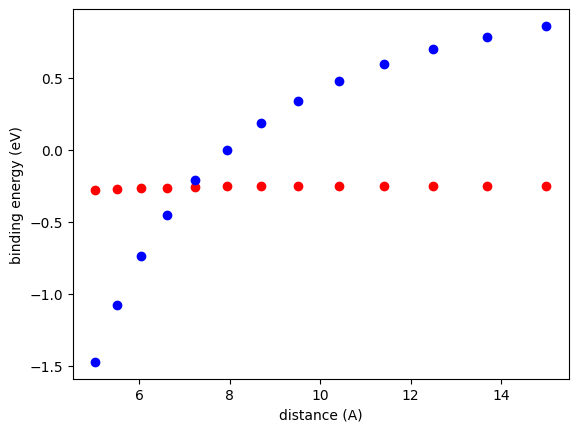

In [112]:
plt.plot(distance_current, pred_energy-ground_state, 'ro')
plt.plot(distance_current, true_energy-ground_state, 'bo')
plt.xlabel('distance (A)')
plt.ylabel("binding energy (eV)")

In [113]:
test_xyz[0].get_potential_energy()

energy graph: torch.Size([1]) torch.Size([20])
energy graph: torch.Size([1]) torch.Size([20])
q_vector from forward: torch.Size([20, 256])
k_vectors shape: torch.Size([983, 3]) torch.return_types.max(
values=tensor([ 7, 14, 14]),
indices=tensor([962, 171,  65])) torch.return_types.min(
values=tensor([0, 0, 0]),
indices=tensor([ 0,  0, 51]))
k_vectors dtype: torch.int64
value from optimized ewald sum: torch.Size([20, 256, 8, 15, 15])
term from value or key: torch.Size([20, 256, 983]) torch.Size([20, 256, 8, 15, 15]) torch.Size([983, 256])
k_pot: torch.Size([983, 256])
k_vectors shape: torch.Size([983, 3]) torch.return_types.max(
values=tensor([ 7, 14, 14]),
indices=tensor([962, 171,  65])) torch.return_types.min(
values=tensor([0, 0, 0]),
indices=tensor([ 0,  0, 51]))
k_vectors dtype: torch.int64
value from optimized ewald sum: torch.Size([20, 256, 8, 15, 15])
term from value or key: torch.Size([20, 256, 983]) torch.Size([20, 256, 8, 15, 15]) torch.Size([983, 256])
v_pot: torch.Size([98

-12893.963490119591

In [114]:
test_true_energy, distance_current = [], []
test_pred_energy = []

for i in range(len(test_xyz)):
    distance_current.append(test_xyz[i].info['distance'])
    test_true_energy.append(test_xyz[i].get_potential_energy())
    train_xyz[i].set_calculator(calculator)
    test_pred_energy.append(test_xyz[i].get_potential_energy())   

/tmp/ipykernel_107872/4257996490.py:7: DeprecationWarning: Please use atoms.calc = calc
  train_xyz[i].set_calculator(calculator)


energy graph: torch.Size([1]) torch.Size([20])
energy graph: torch.Size([1]) torch.Size([20])
q_vector from forward: torch.Size([20, 256])
k_vectors shape: torch.Size([983, 3]) torch.return_types.max(
values=tensor([ 7, 14, 14]),
indices=tensor([962, 171,  65])) torch.return_types.min(
values=tensor([0, 0, 0]),
indices=tensor([ 0,  0, 51]))
k_vectors dtype: torch.int64
value from optimized ewald sum: torch.Size([20, 256, 8, 15, 15])
term from value or key: torch.Size([20, 256, 983]) torch.Size([20, 256, 8, 15, 15]) torch.Size([983, 256])
k_pot: torch.Size([983, 256])
k_vectors shape: torch.Size([983, 3]) torch.return_types.max(
values=tensor([ 7, 14, 14]),
indices=tensor([962, 171,  65])) torch.return_types.min(
values=tensor([0, 0, 0]),
indices=tensor([ 0,  0, 51]))
k_vectors dtype: torch.int64
value from optimized ewald sum: torch.Size([20, 256, 8, 15, 15])
term from value or key: torch.Size([20, 256, 983]) torch.Size([20, 256, 8, 15, 15]) torch.Size([983, 256])
v_pot: torch.Size([98

Text(0, 0.5, 'binding energy (eV)')

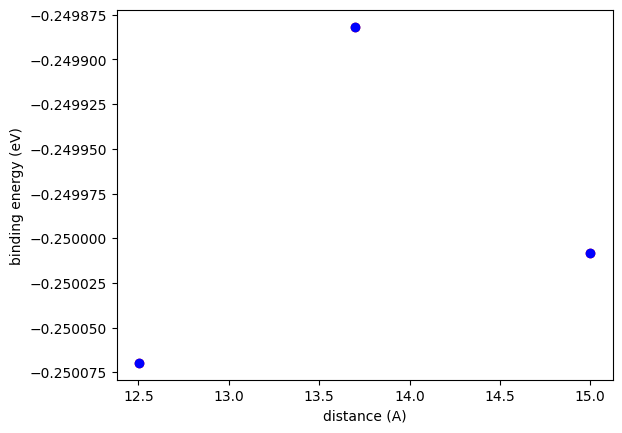

In [115]:
plt.plot(distance_current, test_pred_energy-ground_state, 'ro')
plt.plot(distance_current, test_true_energy-ground_state, 'bo')
plt.xlabel('distance (A)')
plt.ylabel("binding energy (eV)")

In [116]:
test_pred_energy, test_true_energy

([-12893.963490119591, -12893.963302141141, -12893.963428353865],
 [-12893.963490119591, -12893.963302141141, -12893.963428353865])